# OIC-158 TEM Nuclei Segmentation

In [93]:
import napari
import numpy as np
import pyclesperanto as cle
import skimage as sk
from skimage.io import imread, imsave
import pandas as pd
import os
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
img_files = sorted(glob("E:/Fondufe-Mittendorf_Lab/TEM_Images/Images/*.tif"))
mask_files = sorted(glob("E:/Fondufe-Mittendorf_Lab/TEM_Images/Masks/*.tif"))
imgs = list(map(imread,img_files))
masks = list(map(imread,mask_files))

In [12]:
filtered_masks = [sk.segmentation.clear_border(mask) for mask in masks]

In [15]:
label_stack = np.stack(filtered_masks, axis=0)

In [34]:
viewer = napari.view_image(label_stack)

In [87]:
#to get the number of fragments of nuclei, current min size setting will not remove small intended nuclei fragments
test_mask = filtered_masks[11]
filtered_props = sk.measure.regionprops(test_mask)
relabeled = sk.morphology.remove_small_objects(sk.measure.label(test_mask),min_size=50) #add this layer as an "intensity image" to get the nuc ID it belongs to, low min size to remove small disconnected pixels from ground truth labels
relabel_props = sk.measure.regionprops(relabeled)
for i in range(len(relabel_props)):
    print('label:', relabel_props[i].label)


# viewer = napari.view_image(relabeled)
# viewer.add_image(masks[11])

label: 1
label: 2


In [ ]:
#erode objects to get a thin outer border (disc size 25 is better option)
footprint_50 = sk.morphology.disk(50)
eroded = sk.morphology.erosion(test_mask,footprint_50)
band_50 = test_mask - eroded
# viewer = napari.view_image(relabeled)
# viewer.add_labels(eroded)
# viewer.add_labels(band_50)

<Labels layer 'band' at 0x20cf25f5060>

In [88]:
test_mask = filtered_masks[11]
footprint_25 = sk.morphology.disk(25)
eroded = sk.morphology.erosion(test_mask,footprint_25)
band_25 = test_mask - eroded
# viewer = napari.view_image(imgs[11])
# viewer.add_labels(eroded)
# viewer.add_labels(band_25, name='25')

### Multi-Otsu testing
4 classes with preprocessing of gaussian sigma=2; use with ground truth masks

Use to measure the dense heterochromatin along the membrane and the nucleoli within the nuclei

In [ ]:
#find threshold or approach that works well for segmenting the dense areas
#multi-otsu
mask = test_mask == 1
gauss = sk.filters.gaussian(imgs[11], sigma=2)
masked_img = mask * gauss
o1,o2,o3 = sk.filters.threshold_multiotsu(image=masked_img, classes=4)



In [61]:
otsu1 = (masked_img < o1)*mask
otsu2 = (masked_img < o2)*mask
otsu3 = (masked_img < o3)*mask

In [62]:
viewer = napari.view_image(imgs[11], name='image')
viewer.add_labels(otsu1, name='otsu1')
viewer.add_labels(otsu2, name='otsu2')
viewer.add_labels(otsu3, name='otsu3')

<Labels layer 'otsu3' at 0x20eea6ed990>

In [116]:
test_img = imgs[24]
test_img = np.asarray(test_img,dtype=np.uint16)

In [117]:
# Correct uneven illumination

adpt_norm = sk.exposure.equalize_adapthist(test_img)
norm = sk.exposure.equalize_hist(test_img)
# viewer = napari.view_image(test_img)
# viewer.add_image(adpt_norm, name='adapt norm')
# viewer.add_image(norm, name='norm')

In [85]:
# add in gamma and contrast adjustment to enhance dense regions
gamma_adjust = sk.exposure.adjust_gamma(adpt_norm, gamma=1.5)
viewer = napari.view_image(adpt_norm)
viewer.add_image(gamma_adjust, name='gamma')

<Image layer 'gamma' at 0x20f1aae89d0>

## Testing Sobel and Canny for segmenting the nuclei

### Canny Testing
Close! But not enough connectivity with the lines from canny


In [72]:
footprint = sk.morphology.disk(6)
top_hat = sk.morphology.black_tophat(adpt_norm)
viewer = napari.view_image(top_hat)

In [86]:
edges = sk.feature.canny(gamma_adjust, sigma=2.4)
viewer = napari.view_image(adpt_norm)
viewer.add_image(edges, name='edges')

<Image layer 'edges' at 0x20f1aae87c0>

## Sobel Testing
Not the best approach for TEM images. Not enough contrast in the staining for sobel to find the features of interest

In [77]:
edges = sk.filters.sobel(adpt_norm)
viewer = napari.view_image(adpt_norm)
viewer.add_image(edges, name='edges')

<Image layer 'edges' at 0x20f38e36860>

## Multi-Otsu on histogram equalized images
Use second otsu value

In [132]:
#test image and masks
test_mask = filtered_masks[4]
test_img = np.asarray(imgs[4],dtype=np.uint16)
adpt_norm = sk.exposure.equalize_adapthist(test_img)

In [134]:
mask = test_mask == 1
gauss = sk.filters.gaussian(adpt_norm, sigma=1)
masked_img = mask * gauss
# o1,o2,o3 = sk.filters.threshold_multiotsu(image=masked_img, classes=4)
# otsu1 = (masked_img < o1)*mask
# otsu2 = (masked_img < o2)*mask
# otsu3 = (masked_img < o3)*mask
viewer = napari.view_image(adpt_norm, name='image')
#viewer.add_labels(otsu1, name='otsu1')
viewer.add_labels(otsu2, name='otsu2')
#viewer.add_labels(otsu3, name='otsu3')

<Labels layer 'otsu2' at 0x20ffcb027d0>

In [122]:
labeled_img = sk.morphology.label(otsu2)
props = ['label','area']
region_props = sk.measure.regionprops_table(labeled_img,properties=props)
df = pd.DataFrame.from_dict(region_props)
areas = np.asarray(df['area'])

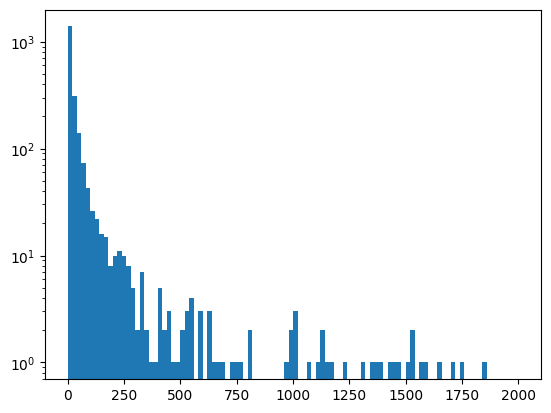

In [123]:
fig, ax = plt.subplots()
ax.hist(areas,bins=100,range=[0,2000])
ax.set_yscale('log')
plt.show()

In [124]:
#filter out small objects and fill holes
filtered = sk.morphology.remove_small_objects(sk.morphology.remove_small_holes(otsu2,area_threshold=10000),min_size=500)
viewer = napari.view_image(adpt_norm, name='img')
viewer.add_labels(filtered, name='labels')
viewer.add_labels(otsu2, name='otsu')

<Labels layer 'otsu' at 0x20fcccc2d40>

In [115]:
viewer.add_labels(band_25,name='band')

<Labels layer 'band' at 0x20fb2b50d00>

## Adding in measurements of heterochromatin in band and nucleoli in nuclei

In [ ]:
view